## What drives milk production?
In this part, we're going to load the following tables and explore them:
<br>
* HistoryAnimal: acts as a DIM-table for the cows in the livestock, containing variables such birth data, number of calves, and breed (BasicAnimal would be an alternative to this table)
* HistoryAnimalDailyData: a table with milking data per cow. Even more data is present in this table compared to AnimalDaily, over 180k records
* SessionMilkYield: table containing information on specific milk sessions. Can be used to calculate time of day of sessions, duration of sessions etc. Has data from March 2017 to April 2018 so might be a good period to start with
* AnimalFeedDailyConsumption: contains information on how much cows have been fed, besides by grazing outside, which cannot be measured with the milking robot. Contains data for a full year, April 2017 - April 2018, which is the time period we'll focus on initially. 
<br>
<br>
After exploring, we're going to try and estimate our first linear regression and see what characteristics (cow, session and feed) affect the total yield (in liters of milk) they provide.

In [10]:
# Load the required packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime as dt

import pyodbc
import sqlalchemy
import urllib

pd.set_option('display.max_columns', 30)

In [2]:
os.chdir("..")
os.chdir("..")

In [3]:
# Connect to SQL Database running in AWS RDS
%run creds.py

params = 'DRIVER=' + creds['driver'] + ';' \
         'SERVER=' + creds['server'] + ';' \
         'DATABASE=' + creds['database'] + ';' \
         'UID=' + creds['user'] + ';' \
         'PWD=' + creds['passwd'] + ';' \
         'PORT=' + str(creds['port']) + ';'
            
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine

db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params, connect_args={'connect_timeout': 360})

In [4]:
## Load the tables from the database
## We'll end up with four dataframes: dim_cow, daily, session and feed
# HistoryAnimal
sql_dim = '''
SELECT *
FROM dbo.HistoryAnimal;
'''
dim_cow = pd.read_sql_query(sql_dim, db)

# HistoryAnimalDailyData
sql_daily = '''
SELECT *
FROM dbo.HistoryAnimalDailyData
WHERE DayDate >= '2017-04-10';
'''
daily = pd.read_sql_query(sql_daily, db)

# SessionMilkYield
sql_session = '''
SELECT *
FROM dbo.SessionMilkYield
WHERE BeginTime >= '2017-04-10';
'''
session = pd.read_sql_query(sql_session, db)

# AnimalFeedDailyConsumption
sql_feed = '''
SELECT *
FROM dbo.AnimalFeedDailyConsumption
WHERE DateAndTime >= '2017-04-10';
'''
feed = pd.read_sql_query(sql_feed, db)

Let's look at the loaded dataframes first.

In [5]:
dim_cow.head()

,OID,Number,OffRegNumber,Name,LastGroup,Gender,Breed,HairColor,BirthDate,LactationNumber,FatherORN,MotherORN,TBCDate,ExitDate,ExitReason,EntryEventDate,ExitType,CullDecisionDate,ReferenceId
0,1,1,NL 326564303,6430,NaN,0,3,None,2001-09-21,7.0,None,None,None,2010-06-25,NaN,2001-09-21,8.0,NaT,1
1,2,2,NL 328831146,3114,NaN,0,3,None,2001-12-02,5.0,None,None,None,2009-09-25,NaN,2001-12-02,8.0,NaT,2
2,3,3,NL 343392637,9263,NaN,0,3,None,2002-01-30,7.0,None,None,None,2012-08-17,NaN,2002-01-30,8.0,NaT,3
3,4,4,NL 343392954,9295,NaN,0,3,None,2002-08-01,5.0,None,None,None,2009-08-24,NaN,2002-08-01,8.0,NaT,4
4,5,5,NL 349017495,1749,NaN,0,3,None,2002-08-21,10.0,None,None,None,2012-10-01,NaN,2002-08-21,8.0,NaT,5


In [6]:
dim_cow['OID'].unique()

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  138,  139,  140,  141,  142,  143,  144,
        145,  146,  147,  148,  149,  150,  151,  1

We're looking for a key to use to join other tables with. <br>
Looks like OID is the unique key for dim_cow, but let's rename it to BasicAnimal for convenience. <br>
Moving on to dataframe daily after that.

In [7]:
dim_cow = dim_cow.rename(columns={'OID': 'BasicAnimal'})

In [8]:
daily.iloc[:,0:11].head()

,OID,DayDate,Animal,Group,LactationNumber,ReproStatus,DIM,DSLC,DailyYield,Last7DayAvg,RelativeYield
0,163178,2017-04-10,143,3,4,3.0,284,284,41.730000,30.154284,103.762121
1,163179,2017-04-10,236,3,1,5.0,232,232,33.500000,27.491428,101.685376
2,163180,2017-04-10,232,3,1,5.0,279,279,26.370001,20.854284,101.459251
3,163181,2017-04-10,191,3,2,5.0,456,456,26.360001,18.531429,104.641418
4,163182,2017-04-10,247,3,1,3.0,48,48,42.040001,33.645714,99.001263


In [9]:
daily.iloc[:,12:22].head()

,Milkings,MilkIncome,ConcConsumed,RoughageConsumed,TotalConsumed,TMRConsumed,PercConsumed,DMConsumed,Feedings,FeedCost
0,3.0,41.730000,6.297,None,6.297,NaN,117.921341,6.297,3.0,0.0
1,3.0,33.500000,7.828,None,7.828,NaN,116.835823,7.828,4.0,0.0
2,3.0,26.370001,1.821,None,1.821,NaN,121.400002,1.821,3.0,0.0
3,3.0,26.360001,1.342,None,1.342,NaN,134.199997,1.342,3.0,0.0
4,4.0,42.040001,9.666,None,9.666,NaN,120.825005,9.666,4.0,0.0


In [12]:
daily.iloc[:,23:33].head()

,Incompletes,AvgConductivity,AvgBlood,AvgCellCount,AvgFat,AvgProtein,AvgBCS,AvgWeight,AvgRectalTemp,BasicAnimal
0,0.0,4.907167,0.00,None,None,None,NaN,NaN,NaN,143
1,0.0,4.237333,0.00,None,None,None,NaN,NaN,NaN,236
2,0.0,4.209333,34.75,None,None,None,NaN,NaN,NaN,232
3,0.0,5.281250,0.00,None,None,None,NaN,NaN,NaN,191
4,0.0,4.274938,0.00,None,None,None,NaN,NaN,NaN,247


In [11]:
daily['BasicAnimal'].unique()

array([ 143,  236,  232,  191,  247,  245,  241,  234,  215,  224,  230,
        182,  218,  243,  175,  228,  181,  217,  250,  118,  173,  193,
        207,  134,  188,  221,  242,  229,  219,  240,  208,  171,  237,
        244,  165,  246,  239,  231,  233,  201,  200,  198,  183,  131,
        148,  147,  140,  161,  206,  248,  146,  249,  235,  251,  204,
        158,  211,  104,  226,  107,  160,  225,  145,  252,  253,  254,
        255,  256,  222,  196,  227, 1253, 2253,  176, 2254, 2255, 2256,
        114, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266,
       2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277])

Dataframe session also contains a bit more columns, therefore we split the head-commands in three parts.

In [13]:
session.iloc[:,0:10].head()

,SessionNo,TotalYield,Destination,User,ExpectedYield,ObjectGuid,BeginTime,BasicAnimal,AnimalDaily,EndTime
0,1,10.89,1,None,10.840,168D81C6-3279-45F8-991C-3E33540B7905,2017-04-10 00:05:34,236,163179,2017-04-10 00:12:46
1,1,8.91,1,None,9.103,630219CE-95E1-49B8-9021-3C1B68EB980A,2017-04-10 00:13:18,232,163180,2017-04-10 00:17:49
2,1,7.77,1,None,7.836,4821F581-6A36-4C52-93E9-A62E3D7DB992,2017-04-10 00:18:15,191,163181,2017-04-10 00:24:08
3,1,10.69,1,None,10.448,CDAFF067-807D-48F9-BB3B-B60EB02C5318,2017-04-10 00:24:29,247,163182,2017-04-10 00:33:01
4,1,13.32,1,None,12.701,CA9F7FD5-EBD7-46D4-9EBC-37AF9BDD49DC,2017-04-10 00:34:36,241,163184,2017-04-10 00:40:46


In [14]:
session.iloc[:,11:20].head()

,PreviousEndTime,AvgConductivity,MaxConductivity,AverageConductivity7Days,RelativeConductivity,AverageBlood,MaxBlood,ModifiedSource,SampleTube
0,2017-04-09 15:03:49,4262,0,0,0,None,0,0,0
1,2017-04-09 14:02:16,4256,0,0,0,None,0,0,0
2,2017-04-09 14:16:28,5059,0,0,0,None,0,0,0
3,2017-04-09 17:05:36,4332,0,0,0,None,0,0,0
4,2017-04-09 14:08:58,4286,0,0,0,None,0,0,0


In [15]:
session.iloc[:,21:25].head()

,SampleTubePosition,ObjectType,OID,SystemEntryTimeStamp
0,0,133,1498016,NaT
1,0,133,1498017,NaT
2,0,133,1498018,NaT
3,0,133,1498019,NaT
4,0,133,1498020,NaT


### EDA - Feed

In [16]:
feed.head()

,NoOfVisits,Cost,DryMatterPercentage,RationHistorical,ObjectGuid,DateAndTime,BasicAnimal,AnimalDaily,Feedstuff,ConsumedDaily,GCRecord,OID,SystemEntryTimeStamp
0,3,0.0,100,5.34,FCD9A169-E53C-44DD-AB28-48DED3E5ADC2,2017-04-10,143,163178,2,6.297,None,1497388,NaT
1,4,0.0,100,6.70,58291E2C-251A-4388-97CC-907085C18504,2017-04-10,236,163179,2,7.828,None,1497389,NaT
2,3,0.0,100,1.50,059A9B2D-9544-4617-9FD2-4E10C98DB70C,2017-04-10,232,163180,2,1.821,None,1497390,NaT
3,3,0.0,100,1.00,C62B7F9E-95E6-4E61-863E-EE68AB4081F5,2017-04-10,191,163181,2,1.342,None,1497391,NaT
4,4,0.0,100,8.00,69004CC9-4D87-4778-BE51-77235EFACC3B,2017-04-10,247,163182,1,9.666,None,1497392,NaT


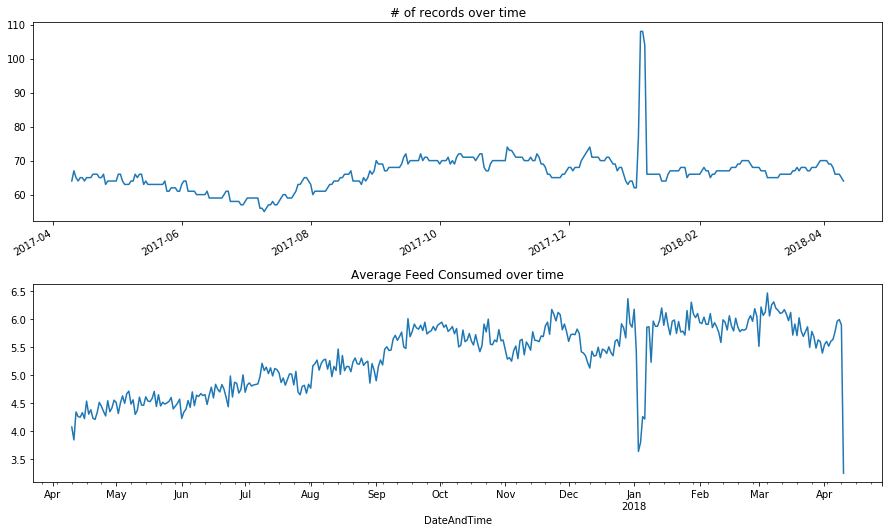

In [45]:
# Check out the number of records and feed consumed over time
plt.subplots(nrows=2, ncols=1, figsize=(12.5,7.5))

plt.subplot(2,1,1)
plt.title('# of records over time')
feed['DateAndTime'].value_counts().plot()

plt.subplot(2,1,2)
plt.title('Average Feed Consumed over time')
feed['ConsumedDaily'].groupby(feed['DateAndTime']).mean().plot()

plt.tight_layout()

Clearly, there is something wrong in the beginning of January.